In [ ]:
#importing package
# %%capture
import sys
#!pip install eli5
!pip install pandas-profiling==2.*
!pip install category_encoders
!pip install pdpbox
!pip install imbalanced-learn
!pip install shap
!pip install catboost

     |████████████████████████████████| 245kB 5.3MB/s 
     |████████████████████████████████| 81kB 6.1MB/s 
     |████████████████████████████████| 81kB 5.5MB/s 
     |████████████████████████████████| 3.1MB 8.4MB/s 
     |████████████████████████████████| 604kB 38.5MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 296kB 50.1MB/s 
  Created wheel for phik: filename=phik-0.11.1-cp37-none-any.whl size=599822 sha256=f071dd6985883ce3b44da3d59b7ff175552946954e418ef43ba2ce9f1fa4e3eb
  Stored in directory: /root/.cache/pip/wheels/0e/c8/42/68bc8b9d86a040d84c1c76fa0104f6e0c89754595843093525
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27085 sha256=4bdb1c9ec0dc04892c733b2ebe6e6016cb8bcdb208a8d7ec4bd0108d00c81032
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
Successfully built phik htmlmin
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you

In [ ]:
#importing packages
%matplotlib inline
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import datetime
import plotly.express as px
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, plot_roc_curve, roc_auc_score
import imblearn
from collections import Counter
import seaborn as sns
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [ ]:
# reading in data
# reading in species csv file
dfs= pd.read_csv('https://raw.githubusercontent.com/TLG229/test-repo/master/whaling_species.csv')

In [ ]:
# reading in voyage csv file
dfv= pd.read_csv('https://raw.githubusercontent.com/TLG229/test-repo/master/voyages.csv', encoding='cp1252') #needed to use this enconding to read in the file

# data wrangling and feature engineering

In [ ]:
#merging dataframes

dfm=pd.merge(dfs, dfv, on='VoyageID')

In [ ]:
#concatinating Month, Day, & Year of observation into single column
dfm['date'] = dfm['Month'].astype(str) + '-'+ dfm['Day'].astype(str) + '-'+ dfm ['Year'].astype(str) 

In [ ]:
#converting date types to datetime
dfm['date'] = pd.to_datetime(dfm['date'])


In [ ]:
#setting 'date' as index
dfm.set_index('date', inplace=True)

In [ ]:
#filling NaN values with 0's for entire dataframe
dfm=dfm.fillna(0)

In [ ]:
# dropping unecessary columns and/or columns that would cause leakage

dfm.drop(columns=['VoyageID','Day','PlaceName','NTried', 'Source', 'sequence','dayOut', 'dayIn','agentID', 'masterID', 'vesselID', 'aowlLink', 'bone', 'sperm', 'oil','Species'], inplace=True)

In [ ]:
dfm['Year'] = (dfm['Year'].astype(int))
dfm['yearOut'] = (dfm['yearOut'].astype(int))
dfm['yearIn'] = (dfm['yearIn'].astype(int))

In [ ]:
#dropping any repeat rows (observations)
dfm.drop_duplicates(inplace=True)

In [ ]:
#converting Encounters into binary - Strike (killed) = 1, NoEnc and Sight = 0
dfm['strike'] = dfm['Encounter'].astype(str).map(lambda x: 1 if 'Strike' in x
                                                             else 0 if 'NoEnc' in x 
                                                             else 0 if 'Sight' in x 
                                                             else"")
    

#EDA

In [ ]:
dfm['strike'].nunique()

2

In [ ]:
#dropping Encounter column
dfm.drop(columns=['Encounter'], inplace = True)

In [ ]:
# how is the target data distributed?
dfm['strike'].value_counts(normalize=True)

0    0.942615
1    0.057385
Name: strike, dtype: float64

In [ ]:
# visualize the target variable
g = sns.countplot(dfm['strike'])
g.set_xticklabels(['No Strike','Stike'])
plt.show()

In [ ]:
dfm['strike'].value_counts()

0    421907
1     25685
Name: strike, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



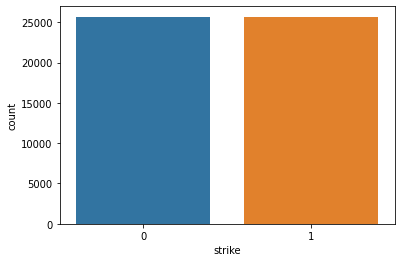

In [ ]:
#Balancing the data by Undersampling the Majority Class
#Shuffling the Dataset
shuffled_df = dfm.sample(frac=1,random_state=42)

#Putting all of the 'strikes' into a separate dataset.
strike_df = shuffled_df.loc[shuffled_df['strike']==1]

#Random selection of 25685 obersvations from the No strike majority class
no_strike_df = shuffled_df.loc[shuffled_df['strike'] ==0].sample(n=25685, random_state=42)

#Concatonating dataframes together
normalized_df = pd.concat([strike_df, no_strike_df])

#plotting the undersampled dataset
plot = sns.countplot(normalized_df['strike'])
g.set_xticklabels(['No Strike','Stike'])
plt.show()

In [ ]:
#grouping by VoyageID into subset DF named df_grouped

df_grouped = normalized_df.groupby('Year')
df_grouped.head()

,Lat,Lon,Month,Year,port,yearOut,yearIn,rig,builtDate,strike
date,,,,,,,,,,
1822-10-22,-38.65,-46.96,10,1822,"Nantucket, MA",1822,1823,Ship,1814.0,1
1838-10-04,27.86,-155.33,10,1838,"New Bedford, MA",1836,1840,Ship,1828.0,1
1838-12-21,-39.06,88.66,12,1838,"New Bedford, MA",1838,1840,Ship,1822.0,1
1847-01-01,-36.33,168.13,1,1847,"New Bedford, MA",1845,1849,Bark,1836.0,1
1844-05-17,42.60,150.50,5,1844,"New Bedford, MA",1842,1845,Ship,1834.0,1
...,...,...,...,...,...,...,...,...,...,...
1807-09-13,41.51,-69.39,9,1807,"Nantucket, MA",1807,1807,Ship,1793.0,0
1805-02-10,-25.40,7.53,2,1805,"Nantucket, MA",1803,1806,Ship,0.0,0
1809-11-09,46.06,-12.30,11,1809,"New Bedford, MA",1809,0,Ship,1803.0,0


#Splitting the Data

In [ ]:
#Splitting target variable and feature matrix

X = normalized_df.drop('strike', axis=1)
y = normalized_df['strike']

In [ ]:
# #Splitting data into training, validation and test sets
cutoff_1 = '1870'
cutoff_2 = '1895'

#training
mask_train = X.index < cutoff_1
X_train, y_train = X.loc[mask_train], y.loc[mask_train]

#validation
mask_val = (X.index >= cutoff_1)&(X.index <= cutoff_2)
X_val, y_val = X.loc[mask_val], y.loc[mask_val]

#test
mask_test = X.index > cutoff_2
X_test, y_test = X.loc[mask_test], y.loc[mask_test]



print('X_Train Shape', X_train.shape, 'y_train Shape:', y_train.shape, 'X_val Shape:', X_val.shape, 'y_val Shape:', y_val.shape, 'X_test Shape', X_test.shape, 'y_test Shape:', y_test.shape)

# X = dfm.drop(['species_enumerated'], axis=1)
# y = dfm['species_enumerated']
# X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)


X_Train Shape (45996, 9) y_train Shape: (45996,) X_val Shape: (3432, 9) y_val Shape: (3432,) X_test Shape (1942, 9) y_test Shape: (1942,)


In [ ]:
y_train.value_counts(normalize=True)

0    0.536895
1    0.463105
Name: strike, dtype: float64

In [ ]:
y_val.value_counts(normalize=True)

1    0.783217
0    0.216783
Name: strike, dtype: float64

#Establish Baseline

In [ ]:
print('Baseline accuracy is {:.4f}.'.format(y_train.value_counts(normalize=True).max()))

Baseline accuracy is 0.5369.


#Builidng Model

In [ ]:
#XGBoost for gradient boosting
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(eta = 0.01, gamma = 10, random_state=42,
                 n_jobs=10))

model_xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['port', 'rig'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'port',
                                          'data_type': dtype('O'),
                                          'mapping': Nantucket, MA                    1
New Bedford, MA                  2
Sag Harbor, NY                   3
Fairhaven, MA                    4
Edgartown, MA                    5
Dartmouth, MA                    6
Mystic, CT                       7
Warren, RI                       8
Fall River, MA                   9
Westport, MA                    10
Bristol, RI                     11
Salem, MA                       1...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, 

In [ ]:
#Checking Metrics
print('XGBoost Training Accuracy:', model_xgb.score(X_train, y_train))
print('XGBoost Validation Accuracy:', model_xgb.score(X_val, y_val))

XGBoost Training Accuracy: 0.7016044873467258
XGBoost Validation Accuracy: 0.7817599067599068


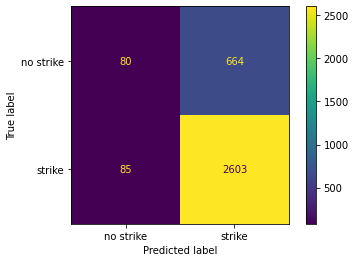

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_xgb, X_val, y_val, values_format='.0f',
display_labels = ['no strike', 'strike'])

In [ ]:
#precision: of all the strikes predicted, proportion of those actually struck
#TP/(TP+FP)
print(2603 / (2603+80))

0.9701826313827805


In [ ]:
#recall:of those struck, what proportion were 
#correctly predicted (TP/TP+FN)
print(2603/(2603+85))

0.9683779761904762


In [ ]:
#using classification report
print(classification_report(y_val,model_xgb.predict(X_val),
                            target_names=['no strike','strike']))

              precision    recall  f1-score   support

   no strike       0.48      0.11      0.18       744
      strike       0.80      0.97      0.87      2688

    accuracy                           0.78      3432
   macro avg       0.64      0.54      0.53      3432
weighted avg       0.73      0.78      0.72      3432



Text(0.5, 1.0, 'Feature Importances for Model XGB Classifier')

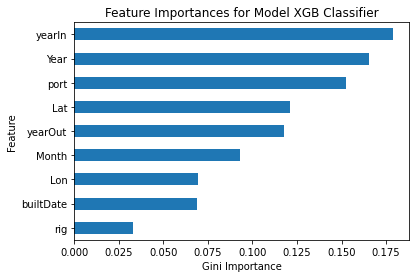

In [ ]:
#Feature Importances
importances = model_xgb.named_steps['xgbclassifier'].feature_importances_
features = X_train.columns

feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel("Feature")
plt.title('Feature Importances for Model XGB Classifier')

In [ ]:
row = X_test.iloc[[12]]
row

,Lat,Lon,Month,Year,port,yearOut,yearIn,rig,builtDate
date,,,,,,,,,
1901-06-06,25.0,-59.0,6,1901,"New Bedford, MA",1899,1901,Bark,1851.0


In [ ]:
y_test.iloc[[12]]

date
1901-06-06    1
Name: strike, dtype: int64

In [ ]:
model_xgb.predict(row)

array([1])

#Communicate Results


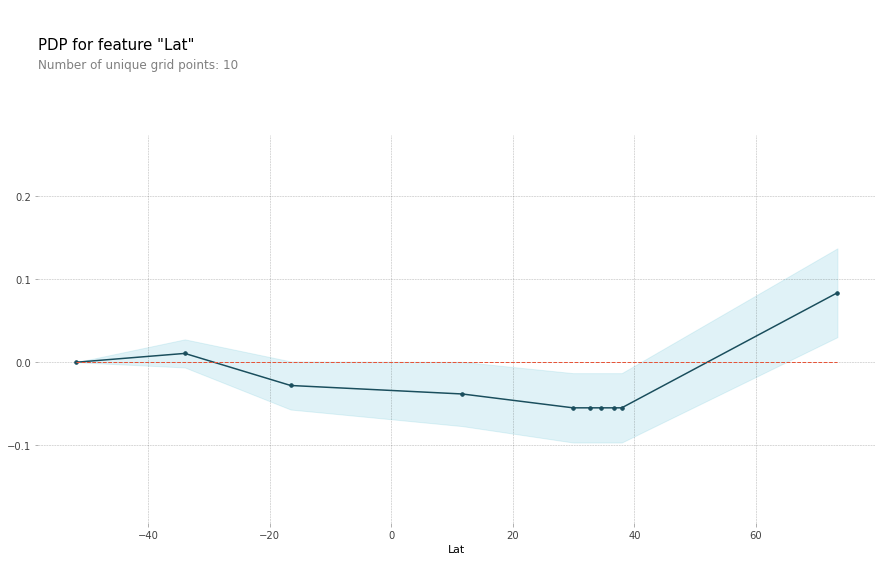

In [ ]:
#PDP Plot for Latitude
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Lat'

#Isolate
isolate = pdp_isolate(
    model = model_xgb,
    dataset=X_test,
    model_features=X_val.columns,
    feature=feature
)
pdp_plot(isolate, feature_name=feature);

# interpretation - generally, as latitude increases, associated kills go down 

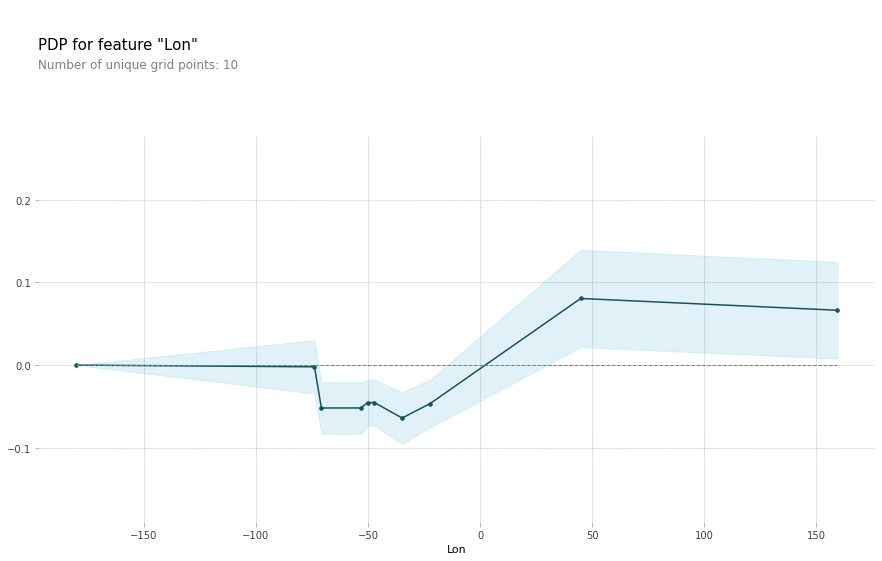

In [ ]:
#PDP Plot for Latitude
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Lon'

#Isolate
isolate = pdp_isolate(
    model = model_xgb,
    dataset=X_test,
    model_features=X_val.columns,
    feature=feature
)
pdp_plot(isolate, feature_name=feature);

#interpretation - as longitude increases, there is a negative influence on kills


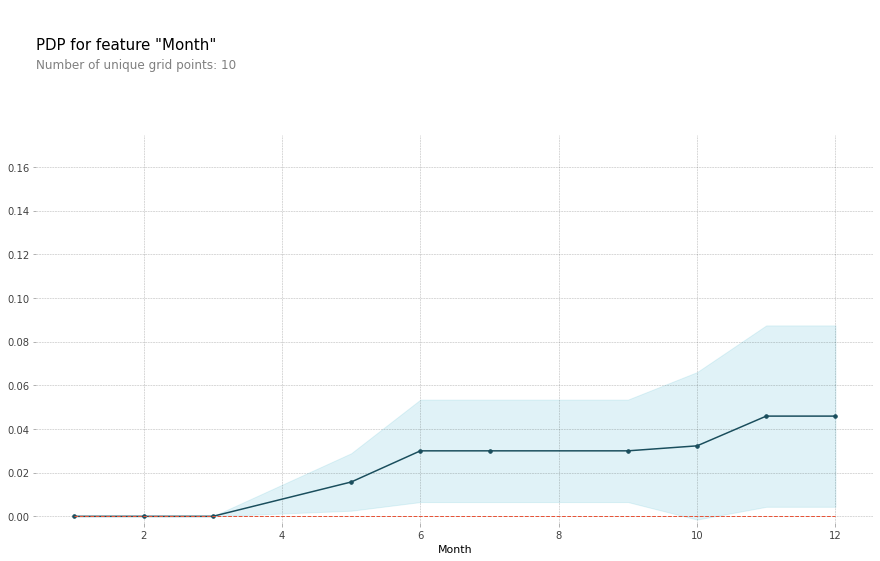

In [ ]:
feature = 'Month'

#Isolate
isolate = pdp_isolate(
    model = model_xgb,
    dataset=X_train,
    model_features=X_train.columns,
    feature=feature
)
pdp_plot(isolate, feature_name=feature);

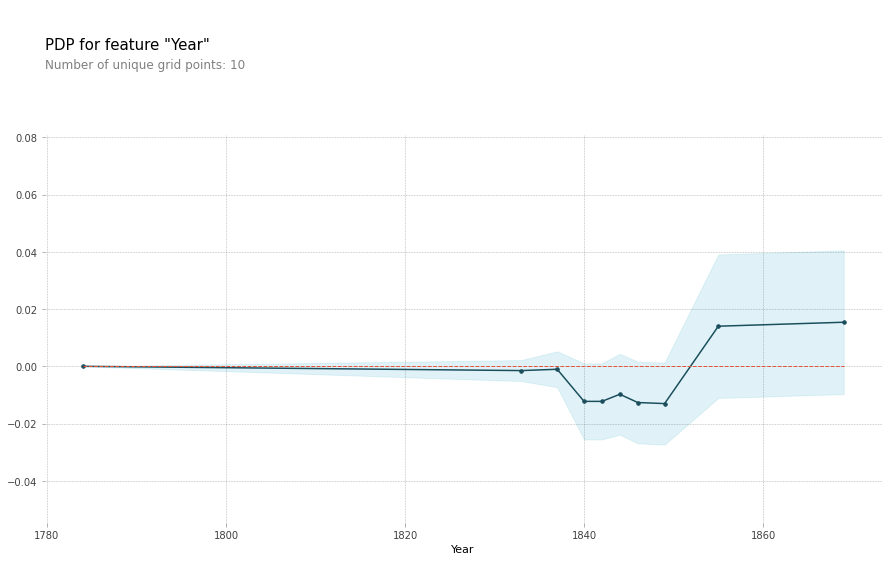

In [ ]:
feature = 'Year'

#Isolate
isolate = pdp_isolate(
    model = model_xgb,
    dataset=X_train,
    model_features=X_train.columns,
    feature=feature
)
pdp_plot(isolate, feature_name=feature);

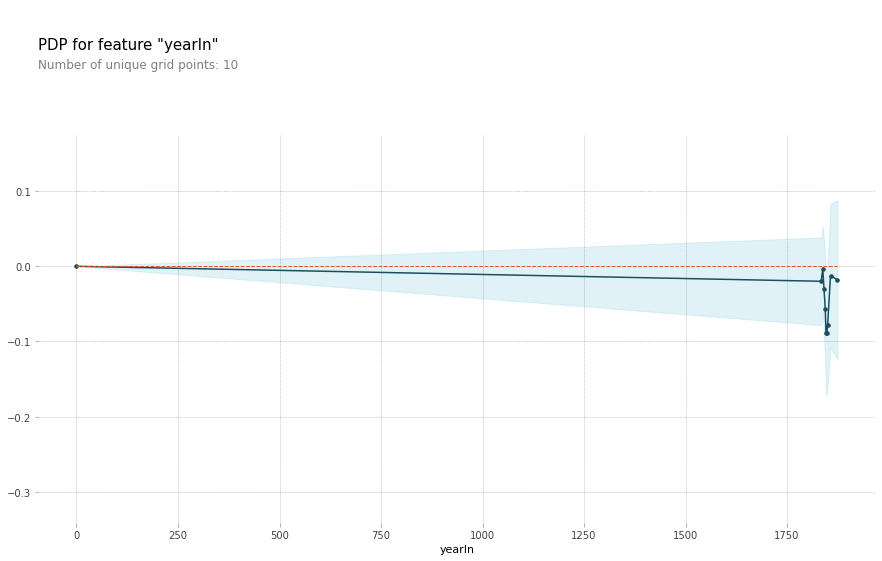

In [ ]:
feature = 'yearIn'

#Isolate
isolate = pdp_isolate(
    model = model_xgb,
    dataset=X_train,
    model_features=X_train.columns,
    feature=feature
)
pdp_plot(isolate, feature_name=feature);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


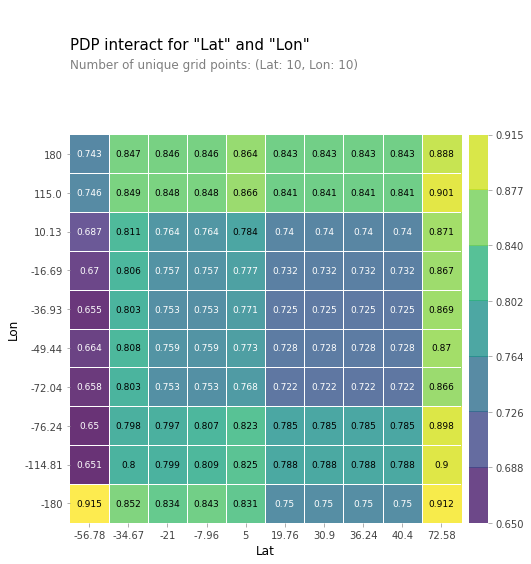

In [ ]:
#pdp interact plot -
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['Lat', 'Lon']

interact = pdp_interact(
    model = model_xgb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot (interact, plot_type='grid', feature_names=features);

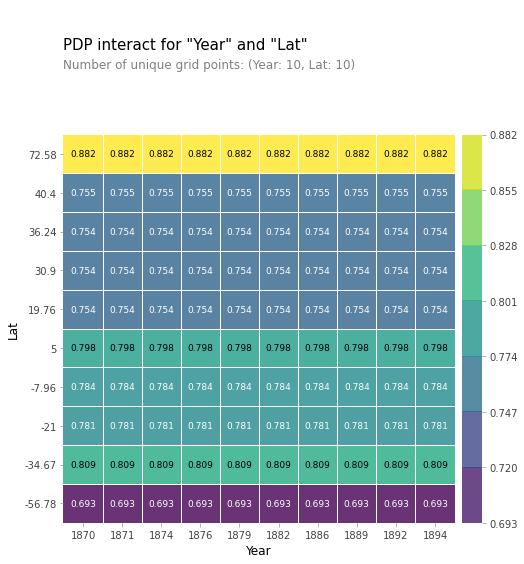

In [ ]:
#pdp interact plot 

features = ['Year', 'Lat']

interact = pdp_interact(
    model = model_xgb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot (interact, plot_type='grid', feature_names=features);